In [3]:
#Ylonka Machado's Notebook for Project 2: Airbnb Bookings

In [6]:
#Importing libraries
import numpy as np
import pandas as pd

#Reading Data
train_df = pd.read_csv("train_users_2.csv")

#Removing rows with no bookings
train_df = train_df[train_df.country_destination != 'NDF']

#Removing timestamp_first_active column because of bad date formatting and signup_flow because there is no 
#explanation of what value means
train_df_2 = train_df.drop(['timestamp_first_active','signup_flow'], axis=1)

In [7]:
#Cleaning Data

#Removing rows with null age values, meaning those with ages over 100 or below 18
train_df_2 = train_df_2[train_df_2.age < 100] 
train_df_2 = train_df_2[train_df_2.age >= 18]

#Removing rows with "-unknown-" gender values
train_df_2 = train_df_2[train_df_2.gender != '-unknown-']

#Removing rows with "-unknown-" first browsers
train_df_2 = train_df_2[train_df_2.first_browser != '-unknown-']

#After all this cleaning, I am down to 72,097 rows! 

#Now for one hot encoding
ohe_feats = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    train_df_2_dummy = pd.get_dummies(train_df_2[f], prefix=f)
    train_df_2 = train_df_2.drop([f], axis=1)
    train_df_2 = pd.concat((train_df_2, train_df_2_dummy), axis=1)
    

In [8]:
#Analysis of Model Performance: Linear Regression
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder

target = train_df_2['country_destination'].values
le = LabelEncoder()
target = le.fit_transform(target)

X = train_df_2.drop(['id','date_account_created','date_first_booking','country_destination'], axis=1)
#print(train_df_2.head())
y = target

lm = linear_model.LinearRegression()
model = lm.fit(X,y)

predictions = lm.predict(X)
print(lm.score(X,y))
#0.75% R^2 score :(

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.00758449162512


In [9]:
#Analyzing Features: Linear Regression
features = list(X)

#Seeing predictors and their respective coefficients
for x in range(len(features)):
    print(features[x],lm.coef_[x])

age -0.00374642482163
gender_FEMALE 1.22040970255e+12
gender_MALE 1.22040970255e+12
gender_OTHER 1.22040970255e+12
signup_method_basic 139767014736.0
signup_method_facebook 139767014736.0
signup_method_google 139767014736.0
language_ca 1134909133.65
language_cs 1134909131.97
language_da 1134909132.93
language_de 1134909132.22
language_el 1134909130.77
language_en 1134909132.71
language_es 1134909132.73
language_fi 1134909132.94
language_fr 1134909132.06
language_hu 1134909133.98
language_is 1134909134.06
language_it 1134909132.36
language_ja 1134909133.01
language_ko 1134909133.07
language_nl 1134909132.57
language_no 1134909132.88
language_pl 1134909131.83
language_pt 1134909133.66
language_ru 1134909132.56
language_sv 1134909133.17
language_th 1134909133.59
language_tr 1134909133.22
language_zh 1134909133.34
affiliate_channel_api -46586011431.1
affiliate_channel_content -46586011431.3
affiliate_channel_direct -46586011431.1
affiliate_channel_other -46586011430.8
affiliate_channel_rem

In [11]:
#Analysis of Model Performance: RandomForest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,verbose=1,n_jobs=-1,oob_score=True,max_features=None,class_weight='balanced')
rf.fit(X,y)

accuracy = rf.score(X,y)
print(accuracy)
#44% accuracy with 150
#44% accuracy with 300

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.4s


0.443103080178


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    3.8s finished


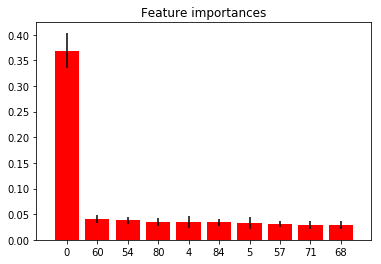

age : 0
first_affiliate_tracked_untracked : 60
first_affiliate_tracked_linked : 54
first_browser_Chrome : 80
signup_method_basic : 4
first_browser_Firefox : 84
signup_method_facebook : 5
first_affiliate_tracked_omg : 57
first_device_type_Windows Desktop : 71
first_device_type_Mac Desktop : 68


In [19]:
#Analyzing Features: RandomForest

#Listing all features and their importance
importances = rf.feature_importances_

for x in range(0,len(importances)):
    print(features[x],":",importances[x])

import matplotlib.pyplot as plt

std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
top_k = 10
new_indices = indices[:top_k]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top_k), importances[new_indices],
       color="r", yerr=std[new_indices], align="center")
plt.xticks(range(top_k), new_indices)
plt.xlim([-1, top_k])
plt.show()

features = list(X)
val_indices = ["0","60","54","80","4","84","5","57","71","68"]
top_10_features = [features[0],features[60],features[54],features[80],features[4],features[84],features[5],features[57],features[71],features[68]]
for x in range(len(top_10_features)):
    print(top_10_features[x],":",val_indices[x])

In [22]:
#Analysis of Model Performance: kNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
#knn3 = KNeighborsClassifier(n_neighbors=3)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(accuracy_score(y_test,pred))

#57% accuracy rate with 3 neighbors
#66% accuracy rate with 5 neigbors

0.659295418456


In [46]:
#Tuning Parameters: kNN
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

#List of Odds for kNN
myList = []
for x in range(6,16):
    if x % 2 != 0:
        myList.append(x)

#List of Cross Validation Scores
cv_scores = []
mse_list = []

#Doing Cross Validation on K = 7
knn7 = KNeighborsClassifier(n_neighbors=7)
score7 = cross_val_score(knn7, X_train, y_train, cv=10, scoring='accuracy')
cv_scores.append(score7.mean())
MSE7 = [1 - score7.mean()]
mse_list.append(MSE7)
print(mse_list)
#MSE was [[0.31233968499577325]] for neighbors = 7

[[0.31233968499577325]]


'\n#Determining optimal number of neighbors\noptimal_k = myList[MSE.index(min(MSE))]\nprint("The optimal number of neighbors is %d" % optimal_k)\n\n# plot misclassification error vs k\nplt.plot(myList, MSE)\nplt.xlabel(\'Number of Neighbors K\')\nplt.ylabel(\'Misclassification Error\')\nplt.show()\n'

In [47]:
#Doing Cross Validation on K = 9
knn9 = KNeighborsClassifier(n_neighbors=9)
score9 = cross_val_score(knn9, X_train, y_train, cv=10, scoring='accuracy')
cv_scores.append(score9.mean())
MSE9 = [1 - score9.mean()]
mse_list.append(MSE9)
print(mse_list)
#MSE for k = 9 was [0.30234617304012001]]

[[0.31233968499577325], [0.30234617304012001]]


In [48]:
#Doing Cross Validation on K = 11
knn11 = KNeighborsClassifier(n_neighbors=11)
score11 = cross_val_score(knn11, X_train, y_train, cv=10, scoring='accuracy')
cv_scores.append(score11.mean())
MSE11 = [1 - score11.mean()]
mse_list.append(MSE11)
print(mse_list)
#MSE for k = 11 was [0.29846435262588089]

[[0.31233968499577325], [0.30234617304012001], [0.29846435262588089]]


In [49]:
#Doing Cross Validation on K = 13
knn13 = KNeighborsClassifier(n_neighbors=13)
score13 = cross_val_score(knn13, X_train, y_train, cv=10, scoring='accuracy')
cv_scores.append(score13.mean())
MSE13 = [1 - score13.mean()]
mse_list.append(MSE13)
print(mse_list)
#MSE for k = 11 was 0.29649491406103801

[[0.31233968499577325], [0.30234617304012001], [0.29846435262588089], [0.29649491406103801]]


In [50]:
#Doing Cross Validation on K = 15
knn15 = KNeighborsClassifier(n_neighbors=15)
score15 = cross_val_score(knn15, X_train, y_train, cv=10, scoring='accuracy')
cv_scores.append(score15.mean())
MSE15 = [1 - score15.mean()]
mse_list.append(MSE15)
print(mse_list)
#MSE for k = 15 was [0.29571253174873857]

[[0.31233968499577325], [0.30234617304012001], [0.29846435262588089], [0.29649491406103801], [0.29571253174873857]]


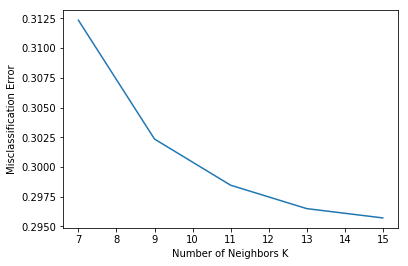

In [70]:
#Determining optimal number of neighbors
#optimal_k = myList[MSE.index(min(MSE))]
optimal_k = min(mse_list)

# plot misclassification error vs k
plt.plot(myList, mse_list)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [56]:
#Running model again with optimal number of neighbors
knn_2 = KNeighborsClassifier(n_neighbors=15)
knn_2.fit(X_train,y_train)
pred_2 = knn_2.predict(X_test)
print(accuracy_score(y_test,pred_2))

0.70240545786
